## For each user, determine her country based on the numeric IP address.

#### 1.Data Summary

In [295]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [296]:
fraud=pd.read_csv('desktop/datachallenge/Fraud/Fraud_Data.csv')
ip=pd.read_csv('desktop/datachallenge/Fraud/IpAddress_to_Country.csv')

In [297]:
fraud.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [298]:
fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
user_id           151112 non-null int64
signup_time       151112 non-null object
purchase_time     151112 non-null object
purchase_value    151112 non-null int64
device_id         151112 non-null object
source            151112 non-null object
browser           151112 non-null object
sex               151112 non-null object
age               151112 non-null int64
ip_address        151112 non-null float64
class             151112 non-null int64
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB


In [299]:
ip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138846 entries, 0 to 138845
Data columns (total 3 columns):
lower_bound_ip_address    138846 non-null float64
upper_bound_ip_address    138846 non-null int64
country                   138846 non-null object
dtypes: float64(1), int64(1), object(1)
memory usage: 3.2+ MB


#### 2 Add country to the fraud dataframe

In [300]:
list=[]
for x in fraud.ip_address:
    a=ip.country[(x>ip.lower_bound_ip_address)&(x<ip.upper_bound_ip_address)]
    list.append(a)

In [301]:
new = []
index = 0
for i in list:
    try:
        country = i.tolist()[0]
    except:
        country = 'missing'
    new.append((country))
    index+=1

In [302]:
new=pd.DataFrame(new)
new.columns=['country']
new.head()

,country
0,Japan
1,United States
2,United States
3,missing
4,United States


In [303]:
fraud=pd.concat([fraud,new],axis=1)
fraud.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,missing
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [304]:
fraud[fraud.country=='missing'].count()

user_id           21966
signup_time       21966
purchase_time     21966
purchase_value    21966
device_id         21966
source            21966
browser           21966
sex               21966
age               21966
ip_address        21966
class             21966
country           21966
dtype: int64

In [305]:
fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 12 columns):
user_id           151112 non-null int64
signup_time       151112 non-null object
purchase_time     151112 non-null object
purchase_value    151112 non-null int64
device_id         151112 non-null object
source            151112 non-null object
browser           151112 non-null object
sex               151112 non-null object
age               151112 non-null int64
ip_address        151112 non-null float64
class             151112 non-null int64
country           151112 non-null object
dtypes: float64(1), int64(4), object(7)
memory usage: 13.8+ MB


## Build a model to predict whether an activity is fraudulent or not. Explain how different assumptions about the cost of false positives vs false negatives would impact the model.

#### 3 Data Exploration

#### 3.1 Duration between sign up and purchase

In [306]:
import time
import datetime
def Interval(date1,date2):
    date1=time.strptime(date1,"%Y-%m-%d %H:%M:%S")
    date2=time.strptime(date2,"%Y-%m-%d %H:%M:%S")
    date1=datetime.datetime(date1[0],date1[1],date1[2],date1[3],date1[4],date1[5])
    date2=datetime.datetime(date2[0],date2[1],date2[2],date2[3],date2[4],date2[5])
    return (date2-date1).days

In [307]:
fraud['interval']=fraud.apply(lambda row: Interval(row['signup_time'],row['purchase_time']),axis=1)

#### 3.2 Calculate the usetime of one device in the same day

In [309]:
fraud.groupby(['device_id','interval'],as_index=False)['device_id'].size().to_csv('a')
size=pd.read_csv('a', header=None)
size.columns=['device_id','interval','device_usetime']
fraud = pd.merge(fraud, size, how='left', left_on=['device_id','interval'],right_on=['device_id','interval'])
##shared device id shows a large possibility to fraud

In [294]:
#fraud.groupby(['ip_address'],as_index=False)['ip_address'].size().to_csv('b')
#size2=pd.read_csv('b', header=None)
#size2.columns=['ip_address','ip_usetime']
#fraud = pd.merge(fraud, size2, how='left', left_on=['ip_address'],right_on=['ip_address'])
##same ip equals to same device 

In [311]:
new_fraud=fraud.drop(['user_id','ip_address','device_id','signup_time','purchase_time'],axis=1)
new_fraud.head()

,purchase_value,source,browser,sex,age,class,country,interval,device_usetime
0,34,SEO,Chrome,M,39,0,Japan,52,1
1,16,Ads,Chrome,F,53,0,United States,0,1
2,15,SEO,Opera,M,53,1,United States,0,11
3,44,SEO,Safari,M,41,0,missing,5,1
4,39,Ads,Safari,M,45,0,United States,50,1


#### 3.3 exam the fraud rate

In [313]:
new_fraud[['class','country']].groupby('country').mean().sort_values(by='class',ascending=False).head(20)

,class
country,
Turkmenistan,1.000000
Namibia,0.434783
Sri Lanka,0.419355
Luxembourg,0.388889
Virgin Islands (U.S.),0.333333
Ecuador,0.264151
Tunisia,0.262712
Peru,0.260504
Bolivia,0.245283


In [314]:
new_fraud[['class','source']].groupby('source').mean()

,class
source,
Ads,0.092066
Direct,0.105370
SEO,0.089285


In [315]:
new_fraud[['class','browser']].groupby('browser').mean()

,class
browser,
Chrome,0.098792
FireFox,0.095165
IE,0.086775
Opera,0.089227
Safari,0.090201


In [316]:
new_fraud[['class','sex']].groupby('sex').mean()

,class
sex,
F,0.091007
M,0.095523


In [317]:
new_fraud.age.describe()

count    151112.000000
mean         33.140704
std           8.617733
min          18.000000
25%          27.000000
50%          33.000000
75%          39.000000
max          76.000000
Name: age, dtype: float64

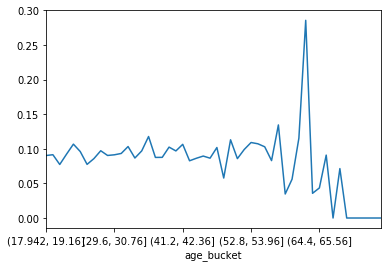

In [318]:
new_fraud['age_bucket'] = pd.cut(new_fraud['age'],50)
new_fraud.groupby('age_bucket')['class'].mean().plot()
plt.show()

In [319]:
#new_fraud.groupby('age_bucket')['class'].mean()

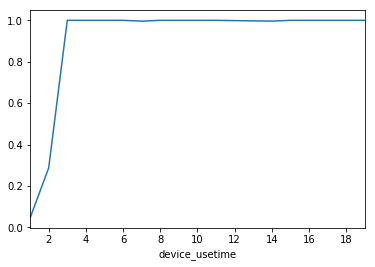

In [320]:
new_fraud.groupby('device_usetime')['class'].mean().plot()
plt.show()

In [321]:
new_fraud['device_usetime_bucket'] = pd.cut(new_fraud['device_usetime'],[0,1,4,8,10,12,15,17,20])
new_fraud.groupby('device_usetime_bucket')['class'].mean()

device_usetime_bucket
(0, 1]      0.045512
(1, 4]      0.575949
(4, 8]      0.998748
(8, 10]     1.000000
(10, 12]    0.999423
(12, 15]    0.997840
(15, 17]    1.000000
(17, 20]    1.000000
Name: class, dtype: float64

In [322]:
new_fraud['device_usetime_bucket'] = pd.cut(new_fraud['device_usetime'],[0,1,4,20])

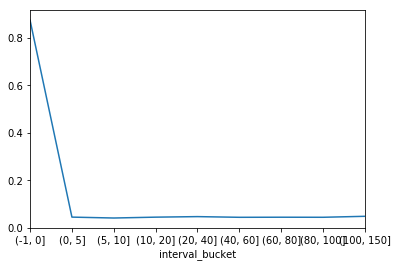

In [323]:
new_fraud['interval_bucket'] = pd.cut(new_fraud['interval'],[-1,0,5,10,20,40,60,80,100,150])
new_fraud.groupby('interval_bucket')['class'].mean().plot()
plt.show()

In [324]:
new_fraud.groupby('interval_bucket')['class'].mean()

interval_bucket
(-1, 0]       0.873259
(0, 5]        0.045262
(5, 10]       0.041511
(10, 20]      0.045100
(20, 40]      0.047366
(40, 60]      0.044489
(60, 80]      0.044846
(80, 100]     0.044588
(100, 150]    0.048694
Name: class, dtype: float64

In [325]:
new_fraud['interval_bucket'] = pd.cut(new_fraud['interval'],[-1,0,150])

In [326]:
new_fraud.purchase_value.describe()

count    151112.000000
mean         36.935372
std          18.322762
min           9.000000
25%          22.000000
50%          35.000000
75%          49.000000
max         154.000000
Name: purchase_value, dtype: float64

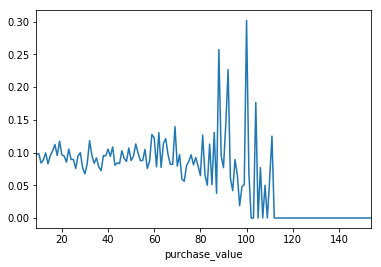

In [327]:
new_fraud.groupby('purchase_value')['class'].mean().plot()
plt.show()

In [328]:
new_fraud.head()

,purchase_value,source,browser,sex,age,class,country,interval,device_usetime,age_bucket,device_usetime_bucket,interval_bucket
0,34,SEO,Chrome,M,39,0,Japan,52,1,"(38.88, 40.04]","(0, 1]","(0, 150]"
1,16,Ads,Chrome,F,53,0,United States,0,1,"(52.8, 53.96]","(0, 1]","(-1, 0]"
2,15,SEO,Opera,M,53,1,United States,0,11,"(52.8, 53.96]","(4, 20]","(-1, 0]"
3,44,SEO,Safari,M,41,0,missing,5,1,"(40.04, 41.2]","(0, 1]","(0, 150]"
4,39,Ads,Safari,M,45,0,United States,50,1,"(44.68, 45.84]","(0, 1]","(0, 150]"


Some insignts:

Signed up and purchased on the same day usually have significant high fraud rate.

Used the same IP address(device) to make 2 or more times of purchase on the same time are usually fraud.

There are no obvious differences for fraud rate across source, browser and sex.

The top 5 fraud rate across country: Turkmenistan, Namibia, Sri Lanka, Luxembourg, Virgin Islands (U.S.)  

#### 4 Model Building

In [253]:
from sklearn.preprocessing import OneHotEncoder
columns=['sex','age_bucket','interval_bucket','device_usetime_bucket','country','source','browser']
features1=pd.get_dummies(new_fraud[columns])
features2=new_fraud[['device_usetime','age','purchase_value']]
data_new=pd.concat([features1,features2],axis=1)

In [254]:
x_train, x_test, y_train, y_test = train_test_split(data_new, new_fraud['class'], test_size=0.2, random_state=1)

In [267]:
alg=RandomForestClassifier(random_state=1,n_estimators=100,min_samples_split=4,min_samples_leaf=2)
kf=cross_validation.KFold(x_train.shape[0],n_folds=5,random_state=1)
scores=cross_validation.cross_val_score(alg,x_train,y_train,cv=kf,scoring='accuracy')
print(scores.mean())

0.956695814928


In [264]:
alg.coef_

AttributeError: 'LogisticRegression' object has no attribute 'coef_'

In [271]:
alg=LogisticRegression(random_state=1,C=10)
scores=cross_validation.cross_val_score(alg,x_train,y_train,cv=5)
print(scores.mean())

0.953502802198


In [272]:
alg.fit(x_train, y_train)
y_pred = alg.predict(x_test)
from sklearn.metrics import precision_score
precision_score(y_test, y_pred)

0.92729439809296776

In [286]:
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
print(fpr)
print(tpr)
print(thresholds)

[ 0.          0.00446037  1.        ]
[ 0.          0.54197144  1.        ]
[2 1 0]


In [287]:
confusion_matrix(y_test, y_pred)

array([[27230,   122],
       [ 1315,  1556]])

In [288]:
np.sum(y_test)

2871

In [289]:
np.sum(y_pred)

1678

In [281]:
from sklearn.metrics import auc
print(auc(fpr, tpr))

0.768755534997


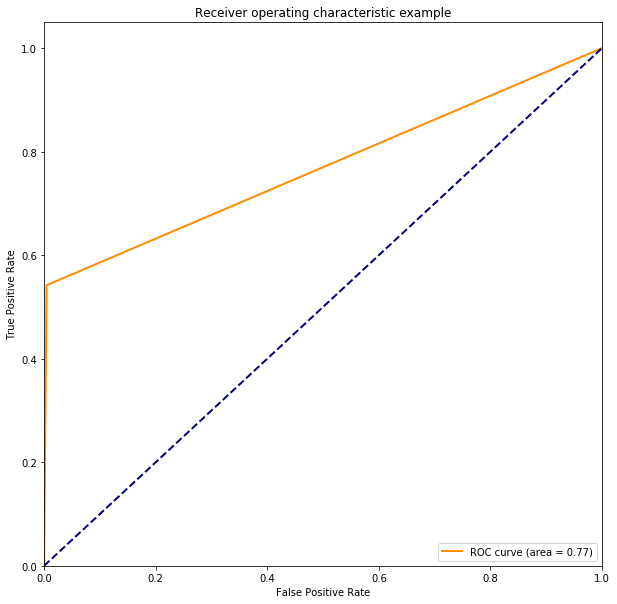

In [280]:
roc_auc = auc(fpr,tpr)
 
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) 
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#### Your boss is a bit worried about using a model she doesn't understand for something as important as fraud detection. How would you explain her how the model is making the predictions? Not from a mathematical perspective (she couldn't care less about that), but from a user perspective. What kinds of users are more likely to be classified as at risk? What are their characteristics?

Based on data exploration, people hardly commit just one fraud. They do as many as possible, once they find a successful strategy. Therefore, the users with the following characteristics are more likely to be classified as at risk:
Users signed up and purchased on the same day usually have significant high fraud rate.
Users used the same IP address to make 2 or more times of purchase on the same time are usually fraud.
Users used the same device to make 3 or more times of purchase on the same time are usually fraud.

Users in the following countries are likely at risk: 
Turkmenistan, Namibia, Sri Lanka, Luxembourg, Virgin Islands (U.S.)

These data exploration results are supported by the logisitic regression model feature analysis, which suggests that:
The two most relevant features to fraud are cout_device and count_ip.
Country, purchase_value, time, source and age are also relevant to fraud.



#### Let's say you now have this model which can be used live to predict in real time if an activity is fraudulent or not. From a product perspective, how would you use it? That is,what kind of different user experiences would you build based on the model output?


The model has very high precision to detect fraud. That said, it has lower false positive rate. If the a fraud is detected by the model, it's very likely that the user is actually at fraud. While, the model has relative low recall and high false negative rate. So, if a user is not recognized as fraud, it still may be at risk. In this case, the risk characteristics such as IP address, device id and country can be further examined for particular user.
 
To be more specificly, if I have a model that tells me that a user has less than 0.1 probability of committing a fraud, I will regard it as normal. If the model shows that a user has more than 0.1 but less than 0.4 probability of committing a fraud, I will ask for two-step authentication. Then, if the probability is higher than 0.4, the user's behavior will be terminated.